<a href="https://colab.research.google.com/github/jnbhandari27/laptop-price-prediction/blob/main/Laptop_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow.compat.v2.feature_column as fc
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
df = pd.read_csv('laptop_price.csv', encoding = 'latin-1')
df['Weight']=df['Weight'].replace('kg','',regex=True).astype(float)
df['Ram']=df['Ram'].replace('GB','',regex=True).astype(int)
df.rename(columns = {'Weight':'Weight (kg)'}, inplace = True)
df.rename(columns = {'Ram':'Ram (GB)'}, inplace = True)

In [5]:
final_dataset = df[['Company', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram (GB)', 'Memory', 'Gpu', 'OpSys', 'Weight (kg)', 'Price_euros']]
final_dataset.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram (GB),Memory,Gpu,OpSys,Weight (kg),Price_euros
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60


In [6]:
columns = list(df)
columns.remove('laptop_ID')
columns

['Company',
 'Product',
 'TypeName',
 'Inches',
 'ScreenResolution',
 'Cpu',
 'Ram (GB)',
 'Memory',
 'Gpu',
 'OpSys',
 'Weight (kg)',
 'Price_euros']

In [7]:
NUMERIC_COLUMNS = ['Inches', 'Weight (kg)', 'Ram (GB)']
CATEGORICAL_COLUMNS = []
for item in columns:
    if item not in (NUMERIC_COLUMNS):
        CATEGORICAL_COLUMNS.append(item)
CATEGORICAL_COLUMNS.remove('Price_euros')
CATEGORICAL_COLUMNS.remove('Product')
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = final_dataset[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='Company', vocabulary_list=('Apple', 'HP', 'Acer', 'Asus', 'Dell', 'Lenovo', 'Chuwi', 'MSI', 'Microsoft', 'Toshiba', 'Huawei', 'Xiaomi', 'Vero', 'Razer', 'Mediacom', 'Samsung', 'Google', 'Fujitsu', 'LG'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='TypeName', vocabulary_list=('Ultrabook', 'Notebook', 'Netbook', 'Gaming', '2 in 1 Convertible', 'Workstation'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='ScreenResolution', vocabulary_list=('IPS Panel Retina Display 2560x1600', '1440x900', 'Full HD 1920x1080', 'IPS Panel Retina Display 2880x1800', '1366x768', 'IPS Panel Full HD 1920x1080', 'IPS Panel Retina Display 2304x1440', 'IPS Panel Full HD / Touchscreen 1920x1080', 'Full HD / Touchscreen 1920x1080', 'Touchscreen / Quad HD+ 3200x1800', 'IPS Panel Touchscreen 1920x1200', 'Touchscreen 2256x1504', 'Quad HD+ / Touchscreen 3200x1800', 'IPS Panel 1366x768', 'I

In [8]:
X = final_dataset.iloc[:,final_dataset.columns!= 'Price_euros']
y = final_dataset['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [9]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(X_train, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(X_test, y_test, num_epochs=1, shuffle=False)


In [10]:
linear_est = tf.estimator.LinearRegressor(
    feature_columns, model_dir=None, label_dimension=1, weight_column=None,
    optimizer='Ftrl', config=None, warm_start_from=None,
    sparse_combiner='sum'
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpxfnqbdct', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [13]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmplebmrupz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [12]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result)  # the result variable is simply a dict of stats about our model

{'average_loss': 1313240.9, 'label/mean': 1178.7135, 'loss': 1287925.1, 'prediction/mean': 284.8274, 'global_step': 580}


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmplebmrupz/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


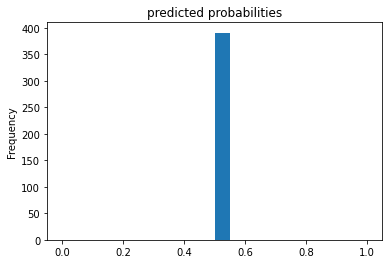

In [15]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')